In [1]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


# Investigating Tax Risk Management

## Summer School JGU Mainz — Advanced Methods in Behavioral Economics, 2021

### Carina I. Hausladen

In [2]:
from datetime import datetime

print(datetime.now().strftime("%Y-%m-%d"))

2021-09-28


In [3]:
import re
import sys
from unicodedata import normalize
from __future__ import print_function
import warnings

warnings.simplefilter("ignore")

import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline

if not sys.warnoptions:
    warnings.simplefilter("ignore")

import nltk
from nltk.stem import WordNetLemmatizer

from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import GroupShuffleSplit

from tqdm import tqdm_notebook

tqdm_notebook().pandas()

0it [00:00, ?it/s]

In [4]:
nltk.download('wordnet');

[nltk_data] Downloading package wordnet to /Users/carinah/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


*Code was developed together with Agajan Torayev and Tobias Elvermann.*
# Introduction
[Lavermicocca (2011)](https://heinonline.org/HOL/Page?handle=hein.journals/ejotaxrs9&div=9&g_sent=1&casa_token=4gQ_iUfuMUEAAAAA:95FZyqAl-ex8Cuk9HMwhLQNlgl1WEVpFDB6hZeLnurXsN1bA_zNg3MjkKBtdz5GK_QO2gD9niTs)

-  How do tax risk management practices of large corporations in Germany look like? 
- More precisely, we want to investigate
    - tax risk decision making 
    - variables that impact tax risk 
    - the ability to manage tax risk 
    - tax risk management practices

# Data
Data and the research idea are provided by [Prof. Dr. Martin Fochmann, FU Berlin](https://www.wiwiss.fu-berlin.de/fachbereich/bwl/pruefungs-steuerlehre/fochmann/Team/Prof_-Dr_-Fochmann/index.html). <br>
Data includes tax reports from German companies listed in the STOXX Europe 600. <br>

y: hand-coded <br>
X: If the keywords tax\* and/or risk\* were found, 15 words before and after the keyword were extracted and entered as a separate row.

In [5]:
df = pd.read_csv('data/tax_risk_data_simulated.csv')
df.head()

,x,company,y1,y2,y3
0,in the event of increases and decreases in val...,acs,1,1,1
1,"ACS Group since 2011, has de? ned a risk con...",acs,1,0,0
2,rec oGnition Revenue is recognised to the...,acs,0,0,0
3,salary is paid into an external fund. In add...,acs,0,0,0
4,"them. The lawsuits, although numerous, repre...",acs,0,0,0


# Descriptive Statistics
## Information on labels (y)

- The labels are hand-coded. 
- Three different labels exist:
    - tax risk rudimentary
    - tax risk extensive
    - tax risk management

The dataset has 23142 entries.
The plot shows that a very low percentage of paragraphs are labeled as referring to tax risk.


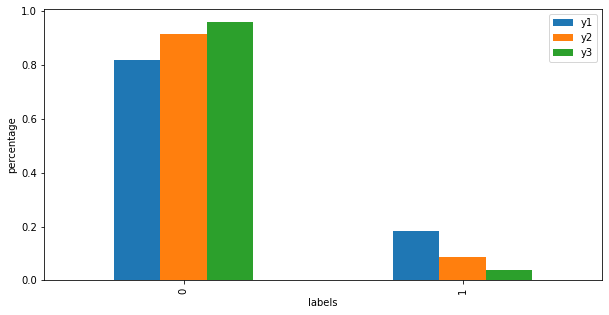

In [6]:
y1_count = df.y1.value_counts(normalize=True)
y2_count = df.y2.value_counts(normalize=True)
y3_count = df.y3.value_counts(normalize=True)

df2 = pd.DataFrame()
df2['y1'] = y1_count
df2['y2'] = y2_count
df2['y3'] = y3_count

print('The dataset has', len(df), 'entries.')
df2.plot.bar(figsize=(10, 5))
plt.xlabel('labels')
plt.ylabel('percentage')
print('The plot shows that a very low percentage of paragraphs are labeled as referring to tax risk.')

## Information by company
The data includes annual reports from German companies listed in the STOXX Europe 600.

In [7]:
y1_count = df.groupby('company')['y1'].sum()
y2_count = df.groupby("company")['y2'].sum()
y3_count = df.groupby("company")['y3'].sum()

df2 = pd.DataFrame()
df2['y1'] = y1_count
df2['y2'] = y2_count
df2['y3'] = y3_count

df2 = df2.sort_values(['y1', 'y2', 'y3'], ascending=[1, 1, 1])  #sort dataframe
count0 = (df2.y1 == 0).sum()  #how many 0
print(f'Out of {len(df2)} companies, {count0} did not talk about tax risk at all.')
df2 = df2.loc[(df2 != 0).any(axis=1)]  #drop companies with all 0

Out of 570 companies, 86 did not talk about tax risk at all.


The plot shows that most of the labels come from very few companies. Therefore key features learnt might be company-specific.

Text(0, 0.5, 'value counts')

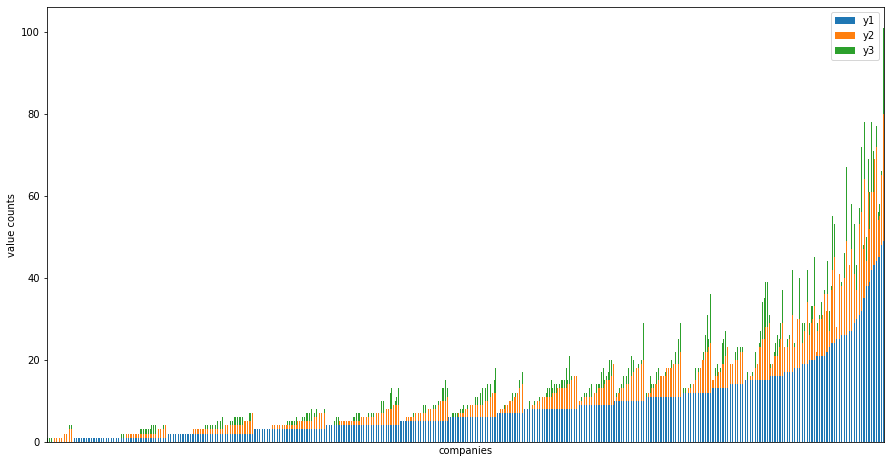

In [8]:
df2.plot.bar(stacked=True, figsize=(15, 8))
plt.xticks([])
plt.xlabel('companies')
plt.ylabel('value counts')

## Annual Reports (X)

In [9]:
print(len(df['x']))

23142


In [10]:
#examine number of words per sample
df['x'].apply(lambda x: len(x.split(" "))).describe()

count    23142.000000
mean       122.467980
std         63.435621
min          9.000000
25%         81.000000
50%        109.000000
75%        147.000000
max        836.000000
Name: x, dtype: float64

### Basics
- Remove capitalization, punctuation, numbers, and stopwords. <br>
- Unicode errors (produce by converting pdf to txt) are normalized via [NLTK](https://www.nltk.org).
- Stop words are going to be removed later (when vectorizing).

In [11]:
def _remove_non_ascii(s):
    return "".join(i for i in s if ord(i) < 128)


def clean_text(text):
    text = text.lower()
    text = normalize('NFKD', text)
    text = re.sub(r'\W+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r"\\", "", text)
    text = re.sub(r"\'", "", text)
    text = re.sub(r"\"", "", text)
    text = re.sub('[^a-zA-Z ?!]+', '', text)
    text = _remove_non_ascii(text)
    text = text.strip()
    return text

### Stemming and Lemmatization

[nlp Stanford](https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html)

- The goal of both stemming and lemmatization is to reduce inflectional forms. 
- Sometimes derivationally related forms of a word should be transformed to a common base form. 


am, are, is $\Rightarrow$ be <br>
car, cars, car's, cars' $\Rightarrow$ ca

- **Stemming** chops off the ends of words and often includes the removal of derivational affixes. 
- **Lemmatization** uses vocabulary and morphological analysis of words. 
    - It aims at removing inflectional endings only. 
    - It returns the base or dictionary form of a word (lemma).

We deploy nltk's [WordNetLemmatizer()](http://www.nltk.org/_modules/nltk/stem/wordnet.html#WordNetLemmatizer) using WordNet's built-in [morphy function](https://wordnet.princeton.edu/documentation/morphy7wn).

In [12]:
print(len(df['x']))
df['x'].head()

23142


0    in the event of increases and decreases in val...
1    ACS Group since  2011, has de? ned a risk  con...
2      rec  oGnition   Revenue is recognised to the...
3    salary is paid   into an external fund. In add...
4      them. The lawsuits, although numerous, repre...
Name: x, dtype: object

In [13]:
lemm = WordNetLemmatizer()
df['tokens'] = df['x'].apply(
    lambda x: " ".join([lemm.lemmatize(w) for w in nltk.word_tokenize(clean_text(x)) if len(w) > 2]))

In [14]:
print(len(df['tokens']))
df['tokens'].head()

23142


0    the event increase and decrease value the moni...
1    ac group since ha ned risk control policy that...
2    rec ognition revenue recognised the extent tha...
3    salary paid into external fund addition turner...
4    them the lawsuit although numerous represent s...
Name: tokens, dtype: object

In [15]:
df.columns = ['x_sentences', 'company', 'y1', 'y2', 'y3', 'x']
df.to_csv("data/interim/tax_risk_tokenized.csv", index=False)

## Train/Test Split
- We split the whole dataset, such that companies are either in the train set or the test set. 
- No company must be in both sets. 
- Why? To ensure our trained model has never seen the group before when it comes to testing. 
- We deploy [GroupShuffleSplit()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html#sklearn.model_selection.GroupShuffleSplit). <br>


In [16]:
gss = GroupShuffleSplit(n_splits=1, train_size=.75, random_state=42)
X = df.x_sentences
y = df.y1
for train_idx, test_idx in gss.split(X, y, df.company):
    print("TRAIN:", train_idx, "TEST:", test_idx)

TRAIN: [   19    20    21 ... 23139 23140 23141] TEST: [    0     1     2 ... 23038 23039 23040]


In [17]:
train_df = df.loc[train_idx]
train_df.reset_index(inplace=True, drop=True)

test_df = df.loc[test_idx]
test_df.reset_index(inplace=True, drop=True)

train_df.head()

,x_sentences,company,y1,y2,y3,x
0,"94 adopted on November 30, 2005. The Commi...",actelion,0,0,0,adopted november the committee ha the followin...
1,"Novem\xAD ber 30, 2005. The Committee has the...",actelion,0,0,0,novem xad ber the committee ha the following t...
2,"\x94 adopted on Novem- ber 30, 2005. The Comm...",actelion,0,0,0,adopted novem ber the committee ha the followi...
3,Committee\x94 adopted on 30 November 2005. Th...,actelion,1,0,0,committee adopted november the committee ha th...
4,with Article 663b pt 12 SCO the Board of Dire...,actelion,0,0,0,with article sco the board director regularly ...


🤓: Make sure you understand why we do this. <br>
🤓: Vary the size of the dataset used for training.

## Save Datasets

In [18]:
train_df.to_csv('data/interim/tax_risk_train.csv', index=False)
test_df.to_csv('data/interim/tax_risk_test.csv', index=False)

# It's your turn! 🧑‍💻 ~10'

# Classification
## Baseline Model
- Vectorizers 
    - bag-of-words
    - tf-idf
- Classifiers 
    - Multinomial Naive Bayes
    - Passive-Aggressive Classifiers
    - Support Vector Machines

In [19]:
train = pd.read_csv('data/interim/tax_risk_train.csv')
test = pd.read_csv('data/interim/tax_risk_test.csv')

### Vectorizer
[scikit-learn](https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction) <br>
- Text cannot be fed directly to the algorithms.
- Classifiers expect numerical feature vectors with a fixed size (rather than the raw text with variable length).
- Vectorization is the process of turning a collection of text documents into numerical feature vectors.

#### Bag of Words
- Tokenization+counting and normalization is called the bag of words representation. 
- Documents are described by word occurrences.
- The relative position information of the words in the document is ignored.

In [20]:
x_train = train.x
x_test = test.x

In [21]:
count_vectorizer = CountVectorizer(stop_words='english')  #removing stopwords
count_train = count_vectorizer.fit_transform(x_train)
count_test = count_vectorizer.transform(x_test)

#### tf-idf
- In a large text corpus, some words are very present (e.g. "the", "a", "is" in English).
- Those words carry little meaningful information.
- Those words shadow the frequencies of rarer yet more interesting terms.
- In order to re-weight the count features, we use the tf–idf transformation.

$$ \text{tf-idf}(t,d) = \text{tf}(t,d) \cdot \text{idf}(t)$$
$$ \text{idf}(t) = log \frac{1+n}{1+\text{df}(n)} + 1 $$

- term frequency (tf): the number of times a term occurs in a given document
- $n$: the total number of documents
- $df(t)$: the number of documents that contain term $t$

- The resulting tf-idf vectors are then normalized by the Euclidean norm:

$$ v_{norm}=\frac{v}{||v||_2}=\frac{v}{\sqrt{v_1^2+v_n^2+...+v_n^2}} $$

In [22]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)
tfidf_train = tfidf_vectorizer.fit_transform(x_train)
tfidf_test = tfidf_vectorizer.transform(x_test)

### Classifier

#### Naive Bayes

- The "naive" assumption: The conditional independence between every pair of features given the value of the class variable. 
- Bayes' theorem: given class variable 
$y$ and dependent feature vector $x_1$,...,$x_n$:

$$
P(y|x_1,...,x_n)=\frac{P(y)P(x_1,...,x_n|y)}{P(x_1,...,x_n)}
$$


- The decoupling of the class conditional feature distributions means that each distribution can be independently estimated as a one-dimensional distribution.
- Advantages
    - NB requires a small amount of training data.
    - NB can be extremely fast.
- Disadvantage
    - Although NB is known as a decent classifier, it is known to be a bad estimator.
    - The probability outputs from `predict_proba` are not to be taken too seriously (more on that when we discuss probability calibration).

#### Multinomial Naive Bayes
[scikit-learn](https://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes)

- [MultinomialNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) implements the naive Bayes algorithm for multinomially distributed data.
- The distribution is parametrized by vectors $\theta_{y}=(\theta_{y1},\theta_{y,2},...,\theta_{yn})$.
- $n$ is the number of features (the size of the vocabulary). 
- $\theta_{yi}$ is the probability $P(x_i|y)$ of feature $i$ appearing in a sample belonging to class $y$.

$$
\hat{\theta}_{yi}=\frac{N_{yi}+\alpha}{N_{y}+\alpha n}
$$

- The smoothing priors $\alpha \geqq 0$ account for features not present in the learning samples and prevents zero probabilities.

🤓: Change the smoothing parameter. Do you encounter zero probabilities?

```python
clf = MultinomialNB()
clf.fit(tfidf_train, y_train)
pred = clf.predict(tfidf_test)
```

#### Passive-Aggressive Algorithms
[scikit-learn](https://scikit-learn.org/stable/modules/linear_model.html#passive-aggressive), [Victor Lavrenko](https://www.youtube.com/watch?v=TJU8NfDdqNQ)

- 
[PassiveAggressiveClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.PassiveAggressiveClassifier.html#sklearn.linear_model.PassiveAggressiveClassifier), intuition: 
    - Passive: if correct classification, keep the model.
    - Aggressive: if incorrect classification, update to adjust to this misclassified example.
- Adequate for large-scale learning. 
- They do not require a learning rate. 
- They include a regularization parameter (step size) $C$.


🤓: Change the loss function. Which one (apart from "hinge") is suitable for a classification task?

```python
linear_clf = PassiveAggressiveClassifier(max_iter=50, loss="hinge",C=1)
linear_clf.fit(tfidf_train, y_train)
pred = linear_clf.predict(tfidf_test)
```

#### Support vector machines 
[scikit-learn](https://scikit-learn.org/stable/modules/svm.html), [Lilly Chen](https://towardsdatascience.com/support-vector-machine-simply-explained-fee28eba5496) <br>
- SVMs find the decision boundary to separate different classes and maximize the margin.
- The function can be used with different kernels. 
- A kernel utilizes existing features, applies transformation, and creates new features. 
- Those new features are the key for SVM to find the nonlinear decision boundary.

🤓: Change the kernel.

```python
linear_clf = svm.SVC()
linear_clf.fit(tfidf_train, y_train)
pred = linear_clf.predict(tfidf_test)
```

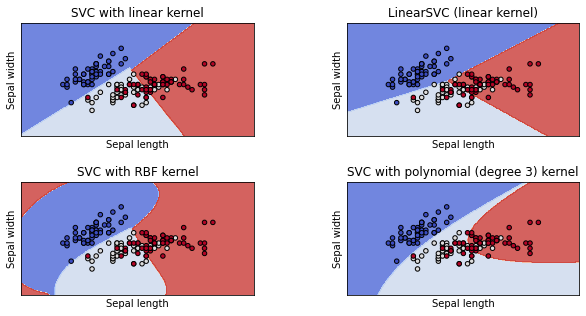

In [23]:
from sklearn import svm, datasets

from utils.visualization import visualize_svms

# import some data to play with
iris = datasets.load_iris()
# Take the first two features. We could avoid this by using a two-dim dataset
X = iris.data[:, :2]
y = iris.target

# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 1.0  # SVM regularization parameter
models = (svm.SVC(kernel='linear', C=C),
          svm.LinearSVC(C=C, max_iter=10000),
          svm.SVC(kernel='rbf', gamma=0.7, C=C),
          svm.SVC(kernel='poly', degree=3, gamma='auto', C=C))
models = (clf.fit(X, y) for clf in models)

# title for the plots
titles = ('SVC with linear kernel',
          'LinearSVC (linear kernel)',
          'SVC with RBF kernel',
          'SVC with polynomial (degree 3) kernel')

visualize_svms(X, y, models, titles, subplot_shape=(2, 2))

In [24]:
results = dict()
most_predictive_features = dict()
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
count_feature_names = count_vectorizer.get_feature_names()

for y in ['y1', 'y2', 'y3']:
    def fit_and_evaluate_model(name, clf, train_data, test_data, feature_names):
        clf.fit(train_data, y_train)
        pred = clf.predict(test_data)
        accuracy = metrics.accuracy_score(y_test, pred, normalize=True, sample_weight=None)
        precision, recall, f1, _ = precision_recall_fscore_support(y_test, pred, average="weighted")
        results[y][name] = {"accuracy": accuracy, "precision": precision, "recall": recall, "f-score": f1}
        coefs = clf.coef_[0] if isinstance(clf.coef_, np.ndarray) else clf.coef_.A[
            0]  # SVM stores coefs as sparse matrix
        most_predictive_features[y][name] = sorted(zip(coefs, feature_names), reverse=True)[
                                            :20]  #most predictive for tax risk = 1


    results[y] = dict()
    most_predictive_features[y] = dict()
    y_train = train[y]
    y_test = test[y]

    #Comparing models:
    #Bayes  
    clf = MultinomialNB()
    fit_and_evaluate_model('MNB_tfidf', clf, tfidf_train, tfidf_test, tfidf_feature_names)
    fit_and_evaluate_model('MNB_count', clf, count_train, count_test, count_feature_names)

    #PassiveAggressive
    clf = PassiveAggressiveClassifier(max_iter=50, loss="hinge", C=1)
    fit_and_evaluate_model('PA_tfidf', clf, tfidf_train, tfidf_test, tfidf_feature_names)
    fit_and_evaluate_model('PA_count', clf, count_train, count_test, count_feature_names)

    #Support Vector Machine
    clf = svm.SVC(kernel='linear', max_iter=50)
    fit_and_evaluate_model('SVM_tfidf', clf, tfidf_train, tfidf_test, tfidf_feature_names)
    fit_and_evaluate_model('SVM_count', clf, count_train, count_test, count_feature_names)

### Plot performance measures
- In the following, we assess the performance of the classifier. 
- We calculate the following metrics: Accuracy, Precision, Recall, and F1-score.
- We will explore those metrics in more detail in the next session. 
- For now, it is sufficient to know how they are called and that they exist.

🤓: Which classifier do you think performs worst?  
🤓: SVM has low performance. Change the parameters, does performance increase?

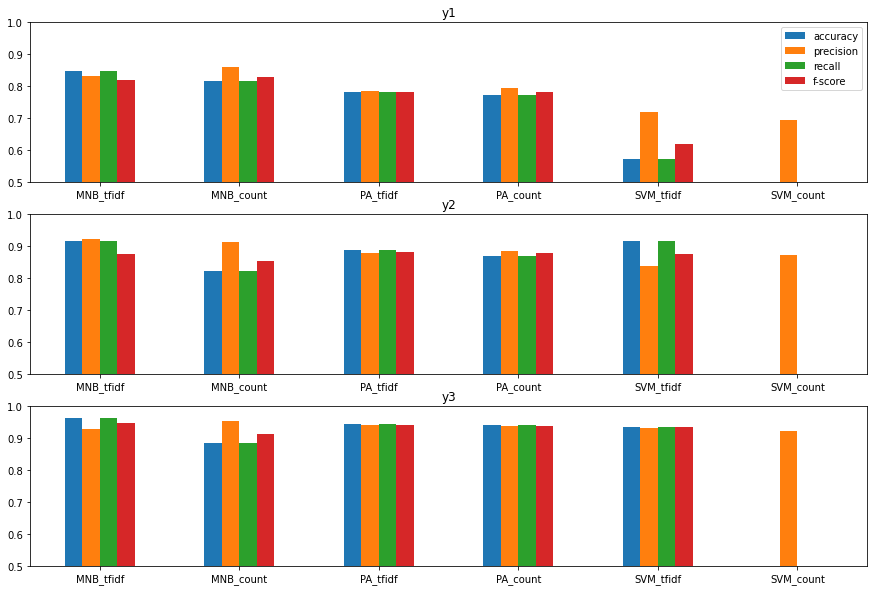

In [25]:
plot_args = {"rot": 0, "figsize": (15, 10), "ylim": (0.5, 1)}
fig, axes = plt.subplots(nrows=3, ncols=1)
pd.DataFrame(results["y1"]).T.plot.bar(ax=axes[0], title="y1", **plot_args)
pd.DataFrame(results["y2"]).T.plot.bar(ax=axes[1], title="y2", legend=False, **plot_args)
pd.DataFrame(results["y3"]).T.plot.bar(ax=axes[2], title="y3", legend=False, **plot_args);

### Introspect features

- One can access the feature importance of many (mostly linear) classifiers in sk-learn. We saved the most predictive features (for class=1) when fitting the classifiers and can now access them.

We can look at the 20 most predictive features for our classifiers. (Please keep in mind that those are less meaningful for weak models)

In [26]:
df = pd.DataFrame()
for y, features in most_predictive_features.items():
    _df = pd.DataFrame(features).applymap(lambda x: x[1])
    _df.columns = pd.MultiIndex.from_product([_df.columns, [y]])
    df = pd.concat([df, _df], axis=1)
df = df.sort_index(axis=1, level=0)
df

MNB_count                           MNB_tfidf                          \
            y1          y2          y3          y1          y2          y3   
0         risk         tax         tax       group       group       group   
1          tax        risk        risk   financial  management  management   
2        group       group       group  management     company     control   
3    financial   financial  management    business   financial  department   
4   management  management     control       legal    business   committee   
5     business     company   financial     control         law      policy   
6       change      change      policy     company   authority  compliance   
7      company    business   committee      change      change    internal   
8        legal   provision    business         law     control       audit   
9         rate      income       audit  regulation       audit   authority   
10     control        rate  compliance   committee      policy    business   
11   provision   liability   provision  compliance   committee   financial   
12       asset         law    internal        rate      income    strategy   
13   liability     control  department  regulatory  compliance       legal   
14      income   authority     company       audit   provision   provision   
15         law       audit        rate      policy   liability     company   
16     related       asset      change     country       legal   liability   
17       audit       legal   authority   liability  regulation       board   
18      market      policy   liability   including      result      change   
19  regulation      result       legal     related  department  governance   

          PA_count                                        PA_tfidf  \
                y1             y2               y3              y1   
0       authorized   supplemented      restitution        introduc   
1         regarded         curred            rubis           onnel   
2           contra    importation     xastatements          column   
3           column       analysed              rom    successively   
4            ected      carefully         opposite      authorized   
5           secure       parental  reconcilliation           raise   
6   postemployment         elster      mandatorily            hort   
7        iteration       compensa        minimises       servicing   
8             xasa        reverse        regularly   replenishment   
9          earning       producer     supplemented   econciliation   
10        leighton         hourly             gilt            dget   
11            adop        claimed          engages       cumulated   
12     accountable  strengthening     particularly    supplemented   
13          elster            fap          djusted      prescribed   
14       investmen     complexity       redundancy        regarded   
15    supplemented           vent      realignment       iteration   
16      critically       xgeneral         pandemic        leighton   
17      prescribed   complianceen       complexity  understandable   
18         culties      virtually        carefully    fitchratings   
19              ge     collective           henkel          contra   

                                      SVM_count                                \
               y2               y3           y1            y2              y3   
0          curren           anking        repor         repor         officer   
1         uipment  reconcilliation      storage           mai           chief   
2          curred          xaevent           sa         owing       financial   
3          hourly      mandatorily       parent      capacity         ensures   
4           nking         xlooking     activity          case           field   
5         reverse              rom     relating    identified  identification   
6            drop            autho       income       segment         applied   
7         claimed 

## Gazetteer versus Random Guess

### Gazetteer
- Gazetteers are named entity dictionaries.
- They can be interpreted as external knowledge sources.
- They include a vast amount of information, for example from Wikipedia (see for example [Higashinaka (2012)](https://aclanthology.org/C12-1071.pdf)
- We follow a very simple strategy:
    - We determine if a paragraph can be considered as containing references to tax risk management or not.
    - If $c$ keywords are present in the text then it can be considered as tax risk management.

In [27]:
train_df = pd.read_csv('data/interim/tax_risk_train.csv')
test_df = pd.read_csv('data/interim/tax_risk_test.csv')

In [28]:
def gazetteer(text, count=1):
    """ 
    Args:
        text: `string` text to analyze
        count: `int` the number of keywords to match

    Returns:
        `Boolean`
    """
    gazetteer = ["tax", "risk", "risks", "group", "financial",
                 "management", "changes", "business", "legal",
                 "company", "authorities", "compliance",
                 "taxes", "regulations", "law", "related", "control", "laws", "committee"]

    # counter
    c = 0
    for g in gazetteer:
        if g in text:
            c += 1
    if c == count:
        return 1
    else:
        return 0

### Random Guess

In [29]:
def random_guess(x):
    """Randomly guess 0 or 1."""
    return np.random.randint(2)

### Evaluation Gazetteer vs. Random Guess

In [30]:
def evaluate_method(X, y, func):
    """Returns classification metrics for an arbitrary X->y mapping function."""
    y_pred = X.map(func)
    accuracy = accuracy_score(y, y_pred, normalize=True, sample_weight=None)
    precision, recall, f1, _ = precision_recall_fscore_support(y, y_pred, average="weighted")
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f-score": f1}


gazetteer_results = {}
for y in ["y1", "y2", "y3"]:
    gazetteer_results[y] = {}
    gazetteer_results[y]["train"] = {}
    gazetteer_results[y]["train"]["random_guess"] = evaluate_method(train_df["x"], train_df[y], random_guess)
    gazetteer_results[y]["train"]["gazetteer"] = evaluate_method(train_df["x"], train_df[y], gazetteer)
    gazetteer_results[y]["test"] = {}
    gazetteer_results[y]["test"]["random_guess"] = evaluate_method(test_df["x"], test_df[y], random_guess)
    gazetteer_results[y]["test"]["gazetteer"] = evaluate_method(test_df["x"], test_df[y], gazetteer)

### Visualization

🤓: Compare the performance of the Gazetteer against one of the baseline models.

In [31]:
def visualize(y_i, verbose=True, ax=None):
    x = ['Gazetteer: Train', 'Random Guess: Train', 'Gazetteer: Test', 'Random Guess: Test']
    y = [gazetteer_results[y_i]["train"]["gazetteer"]["accuracy"],
         gazetteer_results[y_i]["train"]["random_guess"]["accuracy"],
         gazetteer_results[y_i]["test"]["gazetteer"]["accuracy"],
         gazetteer_results[y_i]["test"]["random_guess"]["accuracy"]
         ]
    ax = sns.barplot(x, y, ax=ax)
    ax.set(xlabel='Methods', ylabel='Accuracy')
    ax.set_title(f'{y_i}')
    ax.set(ylim=(0, 1))
    ax.tick_params(labelrotation=25)
    return ax

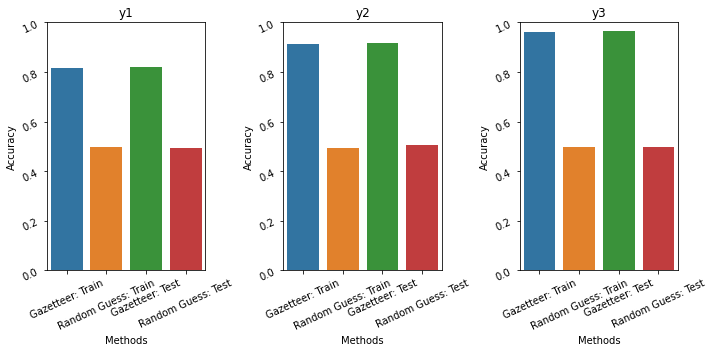

In [32]:
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
visualize('y1', ax=ax[0])
visualize('y2', ax=ax[1])
visualize('y3', ax=ax[2])
plt.tight_layout()

In [33]:
pd.DataFrame(gazetteer_results["y1"]["test"])

,random_guess,gazetteer
accuracy,0.493131,0.819808
precision,0.701546,0.672324
recall,0.493131,0.819808
f-score,0.550690,0.738777


## Save results
(to be used in Session 4)

In [34]:
for y in ["y1", "y2", "y3"]:
    results[y]["gazetteer"] = gazetteer_results[y]["test"]["gazetteer"]

In [35]:
import pickle

with open('data/interim/session2_results.pickle', 'wb') as handle:
    pickle.dump(results, handle)

# It's your turn! 🧑‍💻 ~10'